In [46]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [47]:
import pandas as pd
import numpy as np
from pprint import pprint as pp

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

In [50]:
from collections import Counter
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

In [51]:
from pycaret.classification import *

In [52]:
from helper_methods import make_dataframes_from_classification_report
from helper_methods import print_info_from_pycaret_setup
from helper_methods import find_dataframes_series_from_pycaret_setup, find_train_test_data_from_pycaret_setup

# OBJECTIVE

# preamble
### logical to control dataset sizes for modeling
##### `True` gives very small train and test set sizes for developing and debugging notebook
##### `False` splits entire dataset into train and test

In [53]:
#use_small_data_set = True
use_small_data_set = False

### pickle file name

In [54]:
#running_on_local_machine = True
running_on_local_machine = False

if running_on_local_machine:
    pickle_file_name = 'data/wrangled_data_update_soil.pkl'
    pycaret_results_dir = 'pycaret_df_results/'
else:
    pickle_file_name = '/storage/wrangled_data_update_soil.pkl'
    pycaret_results_dir = '/storage/pycaret_df_results/'

# read wrangled data from pickle

In [55]:
df_data = pd.read_pickle(pickle_file_name)

In [56]:
df_data.shape
df_data.columns
df_data.head()

(581012, 71)

Index(['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology',
       'HD_roadways', 'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'HD_fire_points', 'wild_area_rawah', 'wild_area_neota',
       'wild_area_comanche_peak', 'wild_area_cache_la_poudre', 'soil_type_1',
       'soil_type_2', 'soil_type_3', 'soil_type_4', 'soil_type_5',
       'soil_type_6', 'soil_type_7', 'soil_type_8', 'soil_type_9',
       'soil_type_10', 'soil_type_11', 'soil_type_12', 'soil_type_13',
       'soil_type_14', 'soil_type_15', 'soil_type_16', 'soil_type_17',
       'soil_type_18', 'soil_type_19', 'soil_type_20', 'soil_type_21',
       'soil_type_22', 'soil_type_23', 'soil_type_24', 'soil_type_25',
       'soil_type_26', 'soil_type_27', 'soil_type_28', 'soil_type_29',
       'soil_type_30', 'soil_type_31', 'soil_type_32', 'soil_type_33',
       'soil_type_34', 'soil_type_35', 'soil_type_36', 'soil_type_37',
       'soil_type_38', 'soil_type_39', 'soil_type_40', 'cover_type',
       'wilder

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,...,mms_elevation,mms_aspect,mms_slope,mms_HD_hydrology,mms_VD_hydrology,mms_HD_roadways,mms_hillshade_9am,mms_hillshade_noon,mms_hillshade_3pm,mms_HD_fire_points
0,2596,51,3,258,0,510,221,232,148,6279,...,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366
1,2590,56,2,212,-6,390,220,235,151,6225,...,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838
2,2804,139,9,268,65,3180,234,238,135,6121,...,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339
3,2785,155,18,242,118,3090,238,238,122,6211,...,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886
4,2595,45,2,153,-1,391,220,234,150,6172,...,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449


### define lists of column names

In [57]:
column = 'wild_area_'
areas = ['rawah', 'neota', 'comanche_peak', 'cache_la_poudre']
wild_area_cols = []
for i in areas:
    wild_area_cols.append(column + i)

column = 'soil_type_'
soil_type_cols = []
for i in range(1,41):
    soil_type_cols.append(column + str(i))

numerical_cols = ['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology', 'HD_roadways',
                  'hillshade_9am', 'hillshade_noon', 'hillshade_3pm', 'HD_fire_points']

scaled_numerical_cols = []
for col in numerical_cols:
    scaled_numerical_cols.append('mms_' + col)

target_col = ['cover_type']

target_names = ['spruce_fir', 'lodgepole_pine', 'ponderosa_pine', 'cottonwood_willow', 'aspen', 'douglas_fir', 'krummholz']

reverse_one_hot_cols = ['wilderness_index', 'wilderness_area', 'soil_index']

soil_cluster_cols = ['climatic_zone', 'geologic_zone', 'both_zones']

print('numerical_cols:')
pp(numerical_cols)

print('\nscaled_numerical_cols:')
pp(scaled_numerical_cols)

print('\nwild_area_cols:')
pp(wild_area_cols)

print('\nsoil_type_cols:')
pp(soil_type_cols)

print('\nsoil_cluster_cols:')
pp(soil_cluster_cols)

print('\nreverse_one_hot_cols:')
pp(reverse_one_hot_cols)

print('\ntarget_col:')
pp(target_col)

print('\ntarget_names:')
pp(target_names)

numerical_cols:
['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points']

scaled_numerical_cols:
['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points']

wild_area_cols:
['wild_area_rawah',
 'wild_area_neota',
 'wild_area_comanche_peak',
 'wild_area_cache_la_poudre']

soil_type_cols:
['soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6',
 'soil_type_7',
 'soil_type_8',
 'soil_type_9',
 'soil_type_10',
 'soil_type_11',
 'soil_type_12',
 'soil_type_13',
 'soil_type_14',
 'soil_type_15',
 'soil_type_16',
 'soil_type_17',
 'soil_type_18',
 'soil_type_19',
 'soil_type_20',
 'soil_type_21',
 'soil_type_22',
 'soil_type_23',
 'soil_type_24',
 'soil_type_25',
 'soil_type_26',
 'soil_type_27',
 'soil_type_28',
 's

In [58]:
len(df_data.columns)

71

In [59]:
len(numerical_cols + scaled_numerical_cols + wild_area_cols
    + soil_type_cols + reverse_one_hot_cols + target_col + soil_cluster_cols)

71

# function to build feature columns list

In [60]:
def make_feature_columns_list(numerical_scaled, wild_area_one_hot, soil_type_one_hot, soil_type_cluster='none'):
    feature_cols_list = []
    
    if numerical_scaled:
        feature_cols_list += scaled_numerical_cols
    else:
        feature_cols_list += numerical_cols
    
    if wild_area_one_hot:
        feature_cols_list += wild_area_cols
    else:
        feature_cols_list.append(reverse_one_hot_cols[0])
    
    if soil_type_one_hot:
        feature_cols_list += soil_type_cols
    elif soil_type_cluster=='none':
        feature_cols_list.append(reverse_one_hot_cols[2])
    elif soil_type_cluster=='climatic':
        feature_cols_list.append(soil_cluster_cols[0])
    elif soil_type_cluster=='geologic':
        feature_cols_list.append(soil_cluster_cols[1])
    elif soil_type_cluster=='both':
        feature_cols_list.append(soil_cluster_cols[2])
    else:
        print('ERROR ERROR ERROR ERROR in selection of soil type columns')
    
    return feature_cols_list

In [61]:
temp_list = make_feature_columns_list(numerical_scaled=True, wild_area_one_hot=False,
                                      soil_type_one_hot=False, soil_type_cluster='both')
pp(temp_list)

['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points',
 'wilderness_index',
 'both_zones']


# function to get target name from target integer value

In [62]:
get_target_name_from_integer = lambda i : target_names[i-1]
get_target_name_from_integer(2)

'lodgepole_pine'

# select columns

In [63]:
feature_cols_all = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                                soil_type_one_hot=False, soil_type_cluster='none')
feature_cols_all += soil_cluster_cols
feature_cols_all

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'soil_index',
 'climatic_zone',
 'geologic_zone',
 'both_zones']

# train-test split

In [64]:
if use_small_data_set:
    train_sample_size = 10000
    test_sample_size  = 3000

    X_train, X_test, y_train, y_test = train_test_split(df_data[feature_cols_all], df_data[target_col[0]],
                                       train_size=train_sample_size, test_size=test_sample_size, random_state=59)

else:
    X_train, X_test, y_train, y_test = train_test_split(df_data[feature_cols_all], df_data[target_col[0]],
                                       train_size=0.7, random_state=59)
    

In [65]:
X_train.shape
X_test.shape

(406708, 15)

(174304, 15)

### make dataframe with test and train

In [66]:
df_data_to_use = (pd.concat([X_train, y_train], axis=1)).append(pd.concat([X_test, y_test], axis=1))
df_data_to_use.shape
df_data_to_use.head()

(581012, 16)

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,wilderness_index,soil_index,climatic_zone,geologic_zone,both_zones,cover_type
511216,3153,67,16,256,21,1368,235,206,98,2372,2,39,8,7,87,1
234324,2738,186,17,30,5,1243,220,250,157,1950,2,13,4,7,47,1
446270,3238,13,4,467,203,2816,215,231,152,2942,2,31,7,7,77,1
50042,2759,331,6,124,2,2249,206,233,165,3955,0,12,4,7,47,2
549678,3414,234,21,60,0,2121,180,253,205,3431,1,32,7,7,77,1


### distribution of target values

In [67]:
target_values = df_data[target_col]
target_dist_orig = target_values.value_counts() / len(target_values)
#target_dist_orig

target_values = pd.DataFrame(y_train)
target_dist_train = target_values.value_counts() / len(target_values)
#target_dist_train

target_values = pd.DataFrame(y_test)
target_dist_test = target_values.value_counts() / len(target_values)
#target_dist_test

df_target_dist = pd.DataFrame(zip(target_dist_orig, target_dist_train, target_dist_test),
                              columns=['original', 'train', 'test'],
                              index=target_dist_orig.reset_index()[target_col[0]].values)
#df_target_dist

df_target_dist = df_target_dist.reset_index().rename(columns={'index':target_col[0]})
#df_target_dist

df_target_dist['target_name'] = df_target_dist[target_col[0]].apply(get_target_name_from_integer)

df_target_dist

,cover_type,original,train,test,target_name
0,2,0.487599,0.487586,0.487631,lodgepole_pine
1,1,0.364605,0.364596,0.364627,spruce_fir
2,3,0.061537,0.061622,0.061341,ponderosa_pine
3,7,0.035300,0.035404,0.035059,krummholz
4,6,0.029891,0.029955,0.029741,douglas_fir
5,5,0.016339,0.016115,0.016861,aspen
6,4,0.004728,0.004723,0.004739,cottonwood_willow


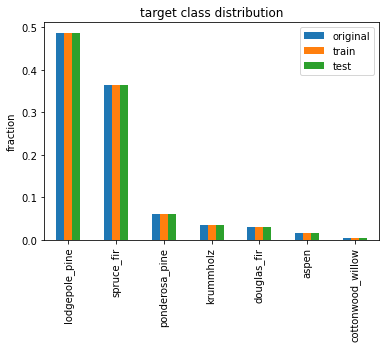

In [68]:
for_plot = ['target_name', 'original', 'train', 'test']
_ = df_target_dist[for_plot].set_index('target_name').plot.bar();
_ = plt.title('target class distribution');
_ = plt.xlabel('')
_ = plt.ylabel('fraction')

# column selection
### min-max scale; 1-hot wild; geologic soil

In [69]:
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='geologic')

features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
df_su = df_data_to_use[cols_to_use]

cols_to_use
features_cat

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'geologic_zone',
 'cover_type']

['wilderness_index', 'geologic_zone']

# `imblearn` preparation
### `pycaret` encodes target classes as `0 to 6` before using `imbalanced_learn`
### `pycaret` one-hot encodes `wilderness_index` before using `imbalanced_learn`   
### `pycaret` applies `imbalanced_learn` to training set (I believe)

In [70]:
# THIS CELL FOR FREQUENCY ENCODING
#features_cat_pycaret_pre_process = features_cat
#features_cat_imblearn = [10, 11, 12, 13, 14]
#features_cat_pycaret_pre_process
#features_cat_imblearn

In [71]:
# THIS CELL FOR GEOLOGIC ENCODING
features_cat_pycaret_pre_process = features_cat
features_cat_imblearn = [10, 11, 12, 13, 14, 15, 16, 17]
features_cat_pycaret_pre_process
features_cat_imblearn

['wilderness_index', 'geologic_zone']

[10, 11, 12, 13, 14, 15, 16, 17]

In [72]:
def create_dict_target_count(orig_counts, dict_factors, train_fraction):
    dict_target_count = {}
    list_classes_clean = []
    
    for target, factor in dict_factors.items():
        dict_target_count[target-1] = int(orig_counts.loc[target].values[0] * factor)
        
        if factor != 1:
            list_classes_clean.append(target-1)
            dict_target_count[target-1] = int(dict_target_count[target-1] * train_fraction)
    
    return dict_target_count, list_classes_clean

In [73]:
target_counts_to_use = df_data_to_use[target_col].value_counts().sort_index()
target_counts_to_use

cover_type
1             211840
2             283301
3              35754
4               2747
5               9493
6              17367
7              20510
dtype: int64

In [74]:
#target_factors = [1, 1, 3.04, 3.14, 3.06, 3.05, 3.02]
dict_factors = {1:1, 2:1, 3:3.04, 4:3.14, 5:3.06, 6:3.05, 7:3.02}
train_fraction = 0.7
dict_target_counts, list_classes_clean = create_dict_target_count(target_counts_to_use, dict_factors, train_fraction)
dict_target_counts
list_classes_clean

{0: 211840, 1: 283301, 2: 76084, 3: 6037, 4: 20333, 5: 37078, 6: 43358}

[2, 3, 4, 5, 6]

In [75]:
the_smote_nc = SMOTENC(categorical_features=features_cat_imblearn, random_state=59,
                       sampling_strategy=dict_target_counts)

the_enn = EditedNearestNeighbours(sampling_strategy=list_classes_clean,
                                  n_neighbors=3, kind_sel='mode')

the_smote = SMOTEENN(random_state=59, smote=the_smote_nc, enn=the_enn)

# `pycaret` `setup`
### `silent = True` to supress interactive confirmation of data types

In [76]:
#su_log_profile = True
su_log_profile = False

su_silent = True
#su_silent = False

#su_log_exp = True
su_log_exp = False

su_use_gpu = False
#su_use_gpu = not running_on_local_machine
print('su_use_gpu = ', su_use_gpu)

su_name_exp = 'imblearn'

su_use_gpu =  False


### variables to hold modeling results

In [77]:
df_pycaret_model_metrics = pd.DataFrame()
df_report_by_class = pd.DataFrame()
df_report_summary  = pd.DataFrame()

In [78]:
def grand_dataframe_creation(the_pycaret_models,
                             the_df_data, train_indices, experiment_name,
                             clear_data_frame=False):
    
    global df_pycaret_model_metrics, df_report_by_class, df_report_summary
    
    if (clear_data_frame):
        df_pycaret_model_metrics = pd.DataFrame()
        df_report_by_class = pd.DataFrame()
        df_report_summary  = pd.DataFrame()
    
    # get pycaret model grid results
    df_pull_temp = pull()
    df_pull_temp.reset_index(drop=True, inplace=True)
    #df_pull_temp['soil encoding'] = experiment_name
    #print('df_pull_temp')
    #print(df_pull_temp)
    df_pycaret_model_metrics = df_pycaret_model_metrics.append(df_pull_temp, ignore_index=True)
    
    for imodel in range(len(the_pycaret_models)):
    #for imodel in range(num_models):
        # predict train data
        pred_train = predict_model(the_pycaret_models[imodel], data = the_df_data.loc[train_indices])
        #print('\npred_train')
        #print(pred_train.shape)
        #print(pred_train.head())

        # metrics by class
        pycaret_target_names = [1, 2, 3, 4, 5, 6, 7]

        df_by_class_temp, df_summary_temp = \
        make_dataframes_from_classification_report(df_pull_temp['Model'].values[imodel],
                                                   'train', pycaret_target_names,
                                                   pred_train['cover_type'], pred_train['Label'])
        #df_by_class_temp['soil encoding'] = experiment_name
        #df_summary_temp['soil encoding']  = experiment_name
        
        # add to master dataframes
        df_report_by_class  = df_report_by_class.append(df_by_class_temp, ignore_index=True)
        df_report_summary   = df_report_summary.append(df_summary_temp, ignore_index=True)
       
    return


# `pycaret` metrics and models
### models
- decision tree
- XGBoost
- CatBoost (use categorical features directly)

In [79]:
def specify_metrics():
    get_metrics(reset=True)

    delete_metrics = ['auc', 'recall', 'kappa', 'mcc']
    for item in delete_metrics:
        remove_metric(item)

    _ = add_metric('re_wgt', 'Recall Weighted', recall_score, average='weighted')

    _ = add_metric('pr_macro', 'Precision Macro', precision_score, average='macro')
    _ = add_metric('re_macro', 'Recall Macro', recall_score, average='macro')
    _ = add_metric('f1_macro', 'F1 Macro', f1_score, average='macro')

In [80]:
#models_to_run = ['dt', 'catboost', 'xgboost']
models_to_run = ['xgboost']
#models_to_run = ['dt', 'catboost']

# experiment
### `setup`

In [81]:
su_grand     = setup(data = df_su, target = target_col[0],
                     categorical_features = features_cat_pycaret_pre_process,
                     normalize = True, normalize_method = 'minmax',
                     fix_imbalance = True, fix_imbalance_method = the_smote,
                     train_size = 0.7, fold = 3, session_id = 59, use_gpu = su_use_gpu,
                     log_experiment = su_log_exp, experiment_name = su_name_exp, log_profile = su_log_profile,
                     #profile = True
                     silent = su_silent
                     )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [82]:
dict_su_data = find_train_test_data_from_pycaret_setup(su_grand,
                                        train_size=int(0.7*len(df_su)), test_size=int(0.3*len(df_su)))
dict_su_data

item= 3 type= <class 'pandas.core.series.Series'> (581012,)
item= 7 type= <class 'pandas.core.frame.DataFrame'> (581012, 13)
item= 9 type= <class 'pandas.core.series.Series'> (174304,)
item= 18 type= <class 'pandas.core.frame.DataFrame'> (174304, 18)
item= 20 type= <class 'pandas.core.frame.DataFrame'> (406708, 18)
item= 32 type= <class 'pandas.core.frame.DataFrame'> (581012, 18)
item= 37 type= <class 'pandas.core.series.Series'> (406708,)


{'X_train': 20, 'y_train': 37, 'X_test': 18, 'y_test': 9}

In [83]:
su_train_indices = su_grand[dict_su_data['X_train']].index
su_test_indices  = su_grand[dict_su_data['X_test']].index
su_train_indices

Int64Index([386294,  93226,   1249, 298742, 469966, 397767,  91286, 324927,
            245109, 411449,
            ...
            528664, 468432, 128653, 222831, 550590, 528447,  23996, 127908,
            543892, 431852],
           dtype='int64', length=406708)

In [84]:
df_su.loc[su_train_indices]

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,wilderness_index,geologic_zone,cover_type
386294,2954,19,17,552,159,3094,206,203,130,886,2,7,2
93226,2926,295,11,306,17,5651,190,237,187,3361,0,2,2
1249,3178,263,9,272,58,5807,197,245,187,2941,0,2,2
298742,2971,132,15,90,9,888,242,232,115,175,2,7,2
469966,3294,1,12,446,98,2758,203,217,152,2325,2,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
528447,3070,250,19,335,44,3443,177,250,209,1549,2,7,1
23996,2860,45,7,402,88,3548,222,224,137,6032,0,7,1
127908,3011,90,7,150,14,4279,231,229,130,684,0,7,2
543892,3216,1,17,366,69,4152,194,206,148,930,2,7,1


In [85]:
columns_X_train = su_grand[dict_su_data['X_train']].columns
len(columns_X_train)
columns_X_train
columns_X_train[features_cat_imblearn]

18

Index(['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology',
       'HD_roadways', 'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'HD_fire_points', 'wilderness_index_0', 'wilderness_index_1',
       'wilderness_index_2', 'wilderness_index_3', 'geologic_zone_1',
       'geologic_zone_2', 'geologic_zone_5', 'geologic_zone_7'],
      dtype='object')

Index(['wilderness_index_0', 'wilderness_index_1', 'wilderness_index_2',
       'wilderness_index_3', 'geologic_zone_1', 'geologic_zone_2',
       'geologic_zone_5', 'geologic_zone_7'],
      dtype='object')

### `compare_models`

In [86]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7efe0cf309d0>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7efe0cf37820>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7efe0cf37700>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7efe0cf37820>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7efe0cf371f0>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [87]:
models_imbl = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8588,0.8585,0.8584,0.8588,0.8462,0.8391,0.8417,994.0500


In [88]:
models_imbl

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=59, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)

### make all dataframes

In [89]:
result_models_list = []
if len(models_to_run)==1:
    print('only 1 model')
    result_models_list.append(models_imbl)
else:
    print('multiple models')
    result_models_list = models_imbl

result_models_list

only 1 model


[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1,
               objective='multi:softprob', random_state=59, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=None, subsample=1,
               tree_method='auto', use_label_encoder=True, validate_parameters=1,
               verbosity=0)]

In [90]:
grand_dataframe_creation(result_models_list, df_su, su_train_indices, su_name_exp)

In [91]:
df_pycaret_model_metrics

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
0,Extreme Gradient Boosting,0.8588,0.8585,0.8584,0.8588,0.8462,0.8391,0.8417,994.05


In [92]:
df_report_by_class

,model,data,class,precision,recall,f1-score,support
0,Extreme Gradient Boosting,train,1,0.860779,0.836518,0.848475,148628
1,Extreme Gradient Boosting,train,2,0.872261,0.886153,0.879152,197906
2,Extreme Gradient Boosting,train,3,0.886500,0.934669,0.909948,25103
3,Extreme Gradient Boosting,train,4,0.941636,0.940166,0.940901,1922
4,Extreme Gradient Boosting,train,5,0.846397,0.722581,0.779603,6665
5,Extreme Gradient Boosting,train,6,0.835721,0.861148,0.848244,12128
6,Extreme Gradient Boosting,train,7,0.931685,0.949986,0.940746,14356


In [93]:
df_report_summary

,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
0,Extreme Gradient Boosting,train,0.870091,0.88214,0.875889,0.878153,0.869856,0.870091,0.869755


### investigate results

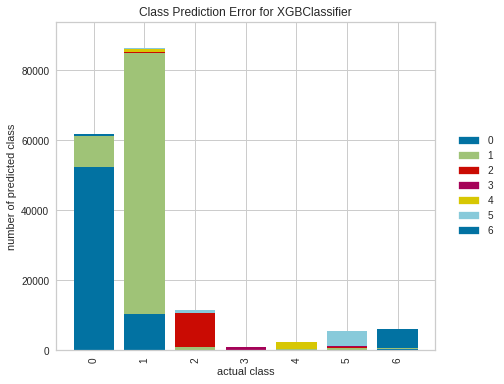

In [94]:
plot_model(models_imbl, plot='error')

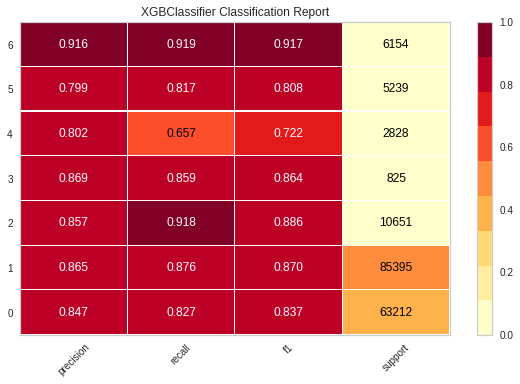

In [95]:
plot_model(models_imbl, plot='class_report')

# pickle result dataframes
### need `protocol=4` to read on local machine (default=5 when run on Paperspace)
https://docs.python.org/3/library/pickle.html

In [96]:
df_pycaret_model_metrics.to_pickle(pycaret_results_dir + 'imblearn_geologic_df_pycaret_model_metrics_xgboost.pkl', protocol=4)
df_report_by_class.to_pickle(pycaret_results_dir + 'imblearn_geologic_df_report_by_class_xgboost.pkl', protocol=4)
df_report_summary.to_pickle(pycaret_results_dir + 'imblearn_geologic_df_report_summary_xgboost.pkl',   protocol=4)

# CONCLUSIONS